# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

<b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks:
1. Load dataset and divide the data into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm
import pandas as pd
from google.colab.patches import cv2_imshow
from os import walk, path
from more_itertools import chunked
import random

In [2]:
!gdown 1CqqAePNPXuvBYDDDajnHFnvgq-Xr1Zyi
!unzip "/content/ATnT.zip" -d "/content"

Downloading...
From: https://drive.google.com/uc?id=1CqqAePNPXuvBYDDDajnHFnvgq-Xr1Zyi
To: /content/ATnT.zip
100% 3.77M/3.77M [00:00<00:00, 175MB/s]
Archive:  /content/ATnT.zip
   creating: /content/ATnT/
  inflating: /content/ATnT/README    
   creating: /content/ATnT/s1/
  inflating: /content/ATnT/s1/1.pgm  
  inflating: /content/ATnT/s1/10.pgm  
  inflating: /content/ATnT/s1/2.pgm  
  inflating: /content/ATnT/s1/3.pgm  
  inflating: /content/ATnT/s1/4.pgm  
  inflating: /content/ATnT/s1/5.pgm  
  inflating: /content/ATnT/s1/6.pgm  
  inflating: /content/ATnT/s1/7.pgm  
  inflating: /content/ATnT/s1/8.pgm  
  inflating: /content/ATnT/s1/9.pgm  
   creating: /content/ATnT/s10/
  inflating: /content/ATnT/s10/1.pgm  
  inflating: /content/ATnT/s10/10.pgm  
  inflating: /content/ATnT/s10/2.pgm  
  inflating: /content/ATnT/s10/3.pgm  
  inflating: /content/ATnT/s10/4.pgm  
  inflating: /content/ATnT/s10/5.pgm  
  inflating: /content/ATnT/s10/6.pgm  
  inflating: /content/ATnT/s10/7.pgm  
 

In [3]:
def print_face_dictionary(att_faces_dict):
    for keys in att_faces_dict:
        print(keys, att_faces_dict[keys])
    # print(keys)

att_faces_dict = {}
for dir_path, dir_names, file_names in walk('./ATnT'):
    for file in file_names:
        image_filename = path.join(dir_path, file)
        # print(image_filename)
        image_frame = cv2.imread(image_filename, 0)
        # print(image_frame)

        if image_frame is not None:
        #   print(image_frame.shape)
        # cv2.imshow('image', frame)
        #   cv2_imshow(image_frame)
        # image_frame_col = np.array(image_frame, dtype='float64').flatten()
        # print(image_frame_col)
            att_faces_dict[image_filename] = image_frame

# att_faces_dict = dict(sorted(att_faces_dict.items()))
# print_face_dictionary(att_faces_dict)

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [4]:
# from google.colab import drive, patches
# drive.mount('/content/drive')


In [5]:
# iterate through all folders, load each image
# fol_path = '/content/drive/MyDrive/SMAI/A2/q3/ATnT'
# fol_path = './AtnT'

# trainAmt = 0.9
# allFaces = []
# labels = []

# for i in range(1,41):
#     for j in range(1,11):
#         imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
#         # imgPath = os.path.join(fol_path, "s" + str(i), str(j) + ".pgm")
#         # print(imgPath)
#         img = cv2.imread(imgPath, -1)
#         # patches.cv2_imshow(img)
#         allFaces.append(img)
#         labels.append(i)

# # shuffle
# randomOrder = np.random.permutation(len(labels))
# allFaces = np.array(allFaces)[randomOrder]
# labels = np.array(labels)[randomOrder]

# # split
# trainFaces = allFaces[:int(trainAmt*len(allFaces))]
# trainLabels = labels[:int(trainAmt*len(allFaces))]

# testFaces = allFaces[int(trainAmt*len(allFaces)): ]
# testLabels = labels[int(trainAmt*len(allFaces)): ]

# # 112x92 (= 10304) grayscale images,  360 in train, 40 in test
# print(trainFaces.shape, trainLabels.shape, testFaces.shape, testLabels.shape)
# print(trainFaces)
# print(trainLabels)
# print(testFaces)
# print(testLabels)

X_train = [] # train_face_set
y_train = [] # train_face_labels
X_test = [] # test_face_set
y_test = [] # test_face_labels

for keys_chunk in chunked(att_faces_dict.keys(), 10):
    # print(keys_chunk)
    # Select a random key from the chunk
    random_key = random.choice(keys_chunk)
    # print(random_key)
    # Iterate over the keys in the chunk
    for key in keys_chunk:
        # print(key)
    #     # keys_list = key.split('/')
    #     # print("keys_list",end="")
    #     # print(keys_list)
    #     # label_list = keys_list[3].split('.')
    #     # print("label_list",end="")
    #     # print(label_list)

    #     # image_label = key
        if key == random_key: # keeping 8.pgm from each folder as test data
            X_test.append(att_faces_dict[key].flatten())
            y_test.append(key)
        else:
            X_train.append(att_faces_dict[key].flatten())
            y_train.append(key)

print(X_train)
print(y_train)
print(X_test)
print(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)
print()
print(X_train.shape)
print(X_train)
print()
print(X_test.shape)
print(X_test)
print()
print(len(y_train))
print(y_train)
print()
print(len(y_test))
print(y_test)

[array([42, 44, 39, ..., 22, 28, 18], dtype=uint8), array([39, 46, 42, ..., 19, 19, 25], dtype=uint8), array([46, 42, 46, ..., 39, 22, 14], dtype=uint8), array([42, 40, 43, ..., 23, 23, 18], dtype=uint8), array([40, 40, 41, ..., 23, 23, 27], dtype=uint8), array([52, 42, 42, ..., 37, 19, 24], dtype=uint8), array([41, 49, 45, ..., 18, 28, 21], dtype=uint8), array([39, 43, 39, ..., 24, 24, 23], dtype=uint8), array([38, 46, 38, ..., 27, 23, 26], dtype=uint8), array([50, 57, 56, ..., 39, 46, 43], dtype=uint8), array([52, 56, 60, ..., 39, 41, 44], dtype=uint8), array([53, 52, 61, ..., 46, 45, 45], dtype=uint8), array([52, 41, 48, ..., 44, 43, 46], dtype=uint8), array([49, 45, 46, ..., 43, 42, 45], dtype=uint8), array([53, 58, 57, ..., 38, 47, 39], dtype=uint8), array([56, 61, 54, ..., 40, 43, 45], dtype=uint8), array([48, 45, 50, ..., 46, 50, 53], dtype=uint8), array([47, 43, 48, ..., 45, 49, 50], dtype=uint8), array([136, 136, 136, ...,  19,  20,  21], dtype=uint8), array([132, 118, 124, ..

#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [6]:
class principalComponentAnalysis:
    def __init__(self, number_of_components=None, mean=None):
        self.components = None
        self.number_of_components = number_of_components
        self.mean = None
        self.eigenvectors = None
        self.eigenvalues = None
        self.eigenfaces = None

    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0)
        X = X - self.mean

        # covariance, function needs samples as columns
        cov = np.cov(X.T)
        # print(cov)
        # print(np.dot(X.T, X) / X.shape[0])

        # eigenvalues, eigenvectors
        self.eigenvalues, self.eigenvectors = np.linalg.eigh(cov)

        # -> eigenvector v = [:,i] column vector, transpose for easier calculations
        # sort eigenvectors
        self.eigenvectors = self.eigenvectors.T
        idxs = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[idxs]
        self.eigenvectors = self.eigenvectors[idxs]

        # store first n self.eigenvectors
        self.components = self.eigenvectors[0 : self.number_of_components]

        self.eigenfaces = self.components

        return X, self.mean, self.eigenvalues, self.eigenvectors, self.eigenfaces

    def transform(self, X):
        # project data
        X = X - self.mean
        # return np.dot(X, self.components.T)
        weights = (self.eigenfaces @ X.T)
        return weights

    def getEigenFacesAndWeights(self, X, first_n_components):
        X = X - self.mean
        first_n_eigenfaces = self.eigenvectors[0 : first_n_components]
        first_n_eigenfaces_weights = (first_n_eigenfaces @ X.T)
        return first_n_eigenfaces, first_n_eigenfaces_weights



pca = principalComponentAnalysis(number_of_components=100)
X_mean, mean, eigenvalues, eigenvectos, eigenfaces = pca.fit(X_train)


Sure, here's a step-by-step explanation of the methods defined in the `principalComponentAnalysis` class along with comments:

```python
class principalComponentAnalysis:
    def __init__(self, number_of_components=None, mean=None):
        self.components = None
        self.number_of_components = number_of_components
        self.mean = None
        self.eigenvectors = None
        self.eigenvalues = None
        self.eigenfaces = None
```
This is the constructor method `__init__`. It initializes various attributes of the PCA class including the number of components to keep (`number_of_components`), mean, eigenvectors, eigenvalues, and eigenfaces.

```python
    def fit(self, X):
        # Mean centering
        self.mean = np.mean(X, axis=0)
        X = X - self.mean
```
The `fit` method calculates the mean of the input data `X` and then subtracts this mean from each data point to center the data around zero.

```python
        # covariance, function needs samples as columns
        cov = np.cov(X.T)
```
The covariance matrix is calculated using `np.cov`. It is calculated on the transposed matrix of the centered data `X.T` because `np.cov` expects features as rows and observations as columns.

```python
        # eigenvalues, eigenvectors
        self.eigenvalues, self.eigenvectors = np.linalg.eigh(cov)
```
Eigenvalues and eigenvectors are computed using `np.linalg.eigh`, which computes the eigenvalues and eigenvectors of a symmetric matrix like the covariance matrix. `eigh` ensures that the eigenvalues are returned in ascending order.

```python
        # sort eigenvectors
        self.eigenvectors = self.eigenvectors.T
        idxs = np.argsort(self.eigenvalues)[::-1]
        self.eigenvalues = self.eigenvalues[idxs]
        self.eigenvectors = self.eigenvectors[idxs]
```
The eigenvectors are sorted based on the corresponding eigenvalues in descending order.

```python
        # store first n self.eigenvectors
        self.components = self.eigenvectors[0 : self.number_of_components]
```
The first `n` eigenvectors, where `n` is defined by `number_of_components`, are stored as `components`.

```python
        self.eigenfaces = self.components
```
The `eigenfaces` are set equal to the `components`.

```python
        return X, self.mean, self.eigenvalues, self.eigenvectors, self.eigenfaces
```
The method returns the mean-centered data `X`, the mean vector, eigenvalues, eigenvectors, and eigenfaces.

```python
    def transform(self, X):
        # project data
        X = X - self.mean
        weights = (self.eigenfaces @ X.T)
        return weights
```
The `transform` method projects the data onto the eigenvectors (or eigenfaces) to obtain the weights.

```python
    def getEigenFacesAndWeights(self, X, first_n_components):
        X = X - self.mean
        first_n_eigenfaces = self.eigenvectors[0 : first_n_components]
        first_n_eigenfaces_weights = (first_n_eigenfaces @ X.T)
        return first_n_eigenfaces, first_n_eigenfaces_weights
```
The `getEigenFacesAndWeights` method returns the first `n` eigenfaces and their corresponding weights, where `n` is specified by `first_n_components`.

```python
pca = principalComponentAnalysis(number_of_components=100)
X_mean, mean, eigenvalues, eigenvectors, eigenfaces = pca.fit(X_train)
```
An instance of the PCA class is created with `number_of_components=100`. The `fit` method is called on `X_train` to calculate the mean, eigenvalues, eigenvectors, and eigenfaces. The mean-centered data, mean vector, eigenvalues, eigenvectors, and eigenfaces are assigned to respective variables.

In [7]:
print("X_mean: ", end="")
print(X_mean)
print("mean: ", end="")
print(mean)
print("all-eigenvectos: ", end="")
print(eigenvectos)
print("eigenvalues: ", end="")
print(eigenvalues)
print("pc-eigenfaces: ", end="")
print(eigenfaces)
print()
print(eigenvectos.shape)
print(eigenvalues.shape)
print(eigenfaces.shape)

X_mean: [[-43.3        -41.23888889 -46.61111111 ... -54.66111111 -47.95
  -57.56944444]
 [-46.3        -39.23888889 -43.61111111 ... -57.66111111 -56.95
  -50.56944444]
 [-39.3        -43.23888889 -39.61111111 ... -37.66111111 -53.95
  -61.56944444]
 ...
 [-44.3        -42.23888889 -42.61111111 ... -31.66111111 -28.95
  -29.56944444]
 [-22.3        -25.23888889 -22.61111111 ... -13.66111111  -6.95
  -17.56944444]
 [-39.3        -40.23888889 -36.61111111 ... -20.66111111 -15.95
  -17.56944444]]
mean: [85.3        85.23888889 85.61111111 ... 76.66111111 75.95
 75.56944444]
all-eigenvectos: [[ 0.00184456  0.00186157  0.00179638 ...  0.00710256  0.0064445
   0.00723236]
 [ 0.01473221  0.01462508  0.01465683 ... -0.01012534 -0.00939617
  -0.00890985]
 [-0.01930046 -0.01943101 -0.0191776  ... -0.01523639 -0.01546384
  -0.01591583]
 ...
 [ 0.          0.38032521 -0.08236187 ...  0.01009326 -0.00469466
  -0.01611683]
 [ 0.          0.46493188 -0.07312621 ...  0.01782177 -0.01474794
  -0.00373

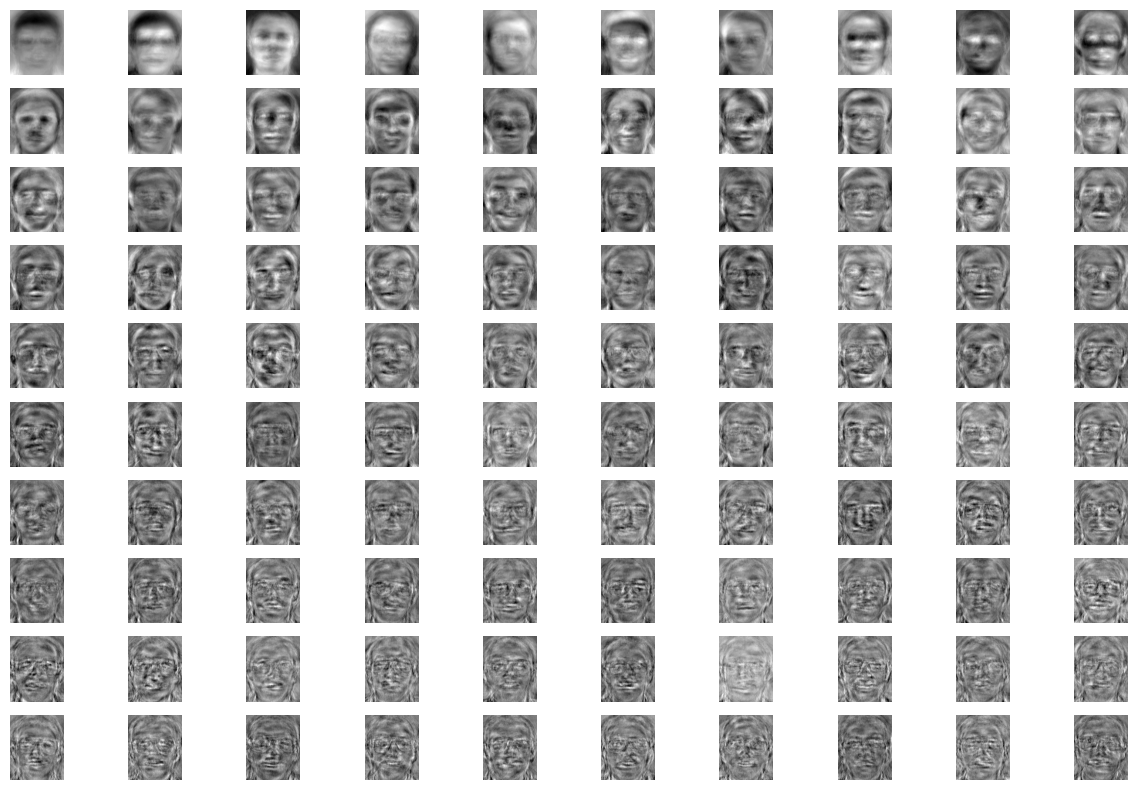

In [8]:
# plot the eigen faces
%matplotlib inline
import matplotlib.pyplot as plt

num_eigenfaces_to_plot = 100

# Reshape and plot the first 50 eigenfaces
fig, axes = plt.subplots(10, 10, figsize=(15, 10))

for i in range(num_eigenfaces_to_plot):
    row = i // 10
    col = i % 10
    eigenface = eigenvectos[i, :].reshape((112, 92))
    axes[row, col].imshow(eigenface, cmap='gray')
    axes[row, col].axis('off')

plt.show()

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [21]:
# def imageReconstruction(testFace, eigenFaces, meanFace):

    # your code here

    # return None

# Function to implement image reconstruction by taking arguements as necessary.
# imageReconstruction(test_image_flatten, mean, first_n_weights, first_n_eigenfaces, y_train)
def imageReconstruction(query_image, mean, weights, eigenfaces, y_train):
    """
    Helper function to reconstruct images
    """
    query_weight = eigenfaces @ (query_image - mean.T).T
    reconstructed_face = (eigenfaces.T @ query_weight).T + mean.T
    # print((query_image - mean).shape)
    # print(reconstructed_face.shape)
    #  + mean.T
    # print(weights.shape)
    # print(query_weight.shape)
    # print(query_image.shape)
    # print(reconstructed_face.shape)
    euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
    euclidean_distance_error = np.linalg.norm(query_image - reconstructed_face, axis = 1)
    # print(euclidean_distance_error.shape)
    # print("euclidean_distance ", end="")
    # print(euclidean_distance)
    best_match = np.argmin(euclidean_distance)
    # print("best_match ", end="")
    # print(best_match)
    print("Best match %s with Euclidean distance %f" % (y_train[best_match], euclidean_distance[best_match]))
    return reconstructed_face, y_train[best_match], euclidean_distance[best_match], euclidean_distance_error


In [10]:
# import numpy as np
# import matplotlib.pyplot as plt

# def getClass(test_image, eigenfaces, mean_face, X_train, y_train):
#     """
#     Arguments:
#     1. Test image
#     2. Eigenvectors
#     3. Mean Eigen Face
#     4. Training Set (X_train, y_train)

#     The function returns the following:
#     1. Image with smallest error
#     2. Error value
#     3. Prediction class
#     """

#     # Project the test image onto the subspace spanned by the eigenfaces
#     test_image_flat = test_image.flatten()
#     coefficients = np.dot(test_image_flat - mean_face, eigenfaces)

#     # Reconstruct the test image
#     reconstructed_image_flat = mean_face + np.dot(coefficients, eigenfaces.T)
#     reconstructed_image = reconstructed_image_flat.reshape(test_image.shape)

#     # Compute the error between the original test image and its reconstruction
#     error = np.linalg.norm(test_image_flat - reconstructed_image_flat)

#     # Find the closest match in the training set
#     min_error = float('inf')
#     min_error_index = None
#     for i, train_image in enumerate(X_train):
#         train_image_flat = train_image.flatten()
#         train_coefficients = np.dot(train_image_flat - mean_face, eigenfaces)
#         train_reconstructed_image_flat = mean_face + np.dot(train_coefficients, eigenfaces.T)
#         train_error = np.linalg.norm(test_image_flat - train_reconstructed_image_flat)
#         if train_error < min_error:
#             min_error = train_error
#             min_error_index = i

#     # Prediction class
#     prediction_class = y_train[min_error_index]

#     return reconstructed_image, error, prediction_class

# # Function to calculate accuracy
# def calculate_accuracy(test_faces, eigenfaces, mean_face, X_train, y_train):
#     correct_predictions = 0
#     total_images = len(test_faces)

#     for test_face, true_label in zip(test_faces, testLabels):
#         _, _, predicted_label = getClass(test_face, eigenfaces, mean_face, X_train, y_train)
#         if predicted_label == true_label:
#             correct_predictions += 1

#     accuracy = (correct_predictions / total_images) * 100
#     return accuracy

# # Function to calculate mean square error
# def calculate_mean_square_error(test_faces, eigenfaces, mean_face, X_train, y_train):
#     mean_square_errors = []

#     for test_face in test_faces:
#         _, error, _ = getClass(test_face, eigenfaces, mean_face, X_train, y_train)
#         mean_square_errors.append(error)

#     return np.mean(mean_square_errors)

# # Function to plot accuracies
# def plot_accuracies(num_components_list, accuracies):
#     plt.plot(num_components_list, accuracies, marker='o')
#     plt.title('Accuracy vs Number of Components')
#     plt.xlabel('Number of Components')
#     plt.ylabel('Accuracy (%)')
#     plt.grid(True)
#     plt.show()

# # Function to plot mean square error
# def plot_mean_square_error(num_components_list, mean_square_errors):
#     plt.plot(num_components_list, mean_square_errors, marker='o')
#     plt.title('Mean Square Error vs Number of Components')
#     plt.xlabel('Number of Components')
#     plt.ylabel('Mean Square Error')
#     plt.grid(True)
#     plt.show()

# # Function to plot semi-log error
# def plot_semi_log_error(num_components_list, mean_square_errors):
#     plt.semilogy(num_components_list, mean_square_errors, marker='o')
#     plt.title('Semi-log Mean Square Error vs Number of Components')
#     plt.xlabel('Number of Components')
#     plt.ylabel('Mean Square Error')
#     plt.grid(True)
#     plt.show()

# # Example usage:
# # Assuming test_faces, trainFaces, trainLabels, eigenfaces, and mean_face are available
# # num_components_list = [5, 10, 20, 50, 100, 200]  # Example list of numbers of components to test
# num_components_list = [3,5,10,20,30,40,50]
# accuracies = []
# mean_square_errors = []

# for num_components in num_components_list:
#     accuracies.append(calculate_accuracy(testFaces, eigenfaces[:, :num_components], mean_face, trainFaces, trainLabels))
#     mean_square_errors.append(calculate_mean_square_error(testFaces, eigenfaces[:, :num_components], mean_face, trainFaces, trainLabels))

# plot_accuracies(num_components_list, accuracies)
# plot_mean_square_error(num_components_list, mean_square_errors)
# plot_semi_log_error(num_components_list, mean_square_errors)

# # Print the accuracies and mean square errors
# for num_components, accuracy, mse in zip(num_components_list, accuracies, mean_square_errors):
#     print(f"Number of components: {num_components}, Accuracy: {accuracy:.2f}%, Mean Square Error: {mse:.2f}")


# # components = [3,5,10,20,30,40,50]
# # mse = []

# # for numComponents in components:
# #     # your code here


# # Example usage:
# # Assuming test_faces, X_train, y_train, eigenfaces, and mean_face are available
# num_components_list = [3,5,10,20,30,40,50]  # Example list of numbers of components to test
# accuracies = []
# mean_square_errors = []

# for num_components in num_components_list:
#     accuracy = calculate_accuracy(testFaces, eigenfaces[:, :num_components], mean_face, trainFaces, trainLabels)
#     accuracies.append(accuracy)
#     mse = calculate_mean_square_error(testFaces, eigenfaces[:, :num_components], mean_face,trainFaces,trainLabels)
#     mean_square_errors.append(mse)

# # Plot accuracies
# plot_accuracies(num_components_list, accuracies)

# # Plot mean square error
# plot_mean_square_error(num_components_list, mean_square_errors)

# # Plot semi-log error
# plot_semi_log_error(num_components_list, mean_square_errors)


# # your code here
# # Example usage:
# # Assuming test_faces, X_train, y_train, eigenfaces, and mean_face are available
# num_components_list = [3,5,10,20,30,40,50]  # Example list of numbers of components to test
# mean_square_errors = []

# for num_components in num_components_list:
#     mse = calculate_mean_square_error(testFaces, eigenfaces[:, :num_components], mean_face,trainFaces,trainLabels)
#     mean_square_errors.append(mse)

# # Plot mean square error
# plot_mean_square_error(num_components_list, mean_square_errors)


# # your code here
# import numpy as np

# # Function to plot logarithmic mean square error
# def plot_log_mean_square_error(num_components_list, mean_square_errors):
#     log_mean_square_errors = np.log(mean_square_errors)
#     plt.plot(num_components_list, log_mean_square_errors, marker='o')
#     plt.title('Logarithmic Mean Square Error vs Number of Components')
#     plt.xlabel('Number of Components')
#     plt.ylabel('Logarithmic Mean Square Error')
#     plt.grid(True)
#     plt.show()

# # Example usage:
# # Assuming test_faces, X_train, y_train, eigenfaces, and mean_face are available
# num_components_list = [3,5,10,20,30,40,50]  # Example list of numbers of components to test
# mean_square_errors = []

# for num_components in num_components_list:
#     mse = calculate_mean_square_error(testFaces, eigenfaces[:, :num_components], mean_face,trainFaces,trainLabels)
#     mean_square_errors.append(mse)

# # Plot logarithmic mean square error
# plot_log_mean_square_error(num_components_list, mean_square_errors)

This code defines a function `imageReconstruction` which is meant to reconstruct images using eigenfaces. Here's a breakdown of the code:

```python
def imageReconstruction(query_image, mean, weights, eigenfaces, y_train):
    """
    Helper function to reconstruct images
    """
```

This is the function definition. It takes five arguments:
- `query_image`: The image to be reconstructed.
- `mean`: The mean face.
- `weights`: The weights obtained from the training data.
- `eigenfaces`: The eigenfaces obtained from the training data.
- `y_train`: Labels associated with the training data.

```python
    query_weight = eigenfaces @ (query_image - mean.T).T
```

This line calculates the weight of the query image using the dot product of `eigenfaces` and the normalized difference between `query_image` and `mean`. The `@` operator is used for matrix multiplication.

```python
    reconstructed_face = (eigenfaces.T @ query_weight).T + mean.T
```

This line reconstructs the face using the calculated weight. It first multiplies the transposed `eigenfaces` with `query_weight`, then adds the mean face. The `.T` is used to transpose matrices.

```python
    euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
```

This calculates the Euclidean distance between the weight of the query image and the weights of the training images. `np.linalg.norm` is used to calculate the Euclidean norm.

```python
    best_match = np.argmin(euclidean_distance)
```

This finds the index of the minimum value in the `euclidean_distance` array, which corresponds to the index of the best-matching image in the training set.

```python
    print("Best match %s with Euclidean distance %f" % (y_train[best_match], euclidean_distance[best_match]))
```

This line prints out the label of the best-matching image along with its Euclidean distance.

```python
    return reconstructed_face, y_train[best_match], euclidean_distance[best_match]
```

Finally, the function returns the reconstructed face, its label, and the Euclidean distance to the best-matching image.

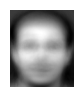

In [11]:
# plot recontructions here
%matplotlib inline
# Create a figure and subplots
fig, axes = plt.subplots(1, 1, figsize=(25, 1))

# Plot first row of images
# count = 0

face = mean.T.reshape((112, 92))
axes.imshow(face, cmap='gray')
axes.axis('off')

plt.show()

#### Visualisation
Visualise the results for different number of factors(components = [3,5,10,20,30,40,50,100])

**Note:** Ensure that the images are labelled appropriately.

In [12]:
# %matplotlib inline

# def displayNfactors():

#     # your code here

#     return None

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [24]:
''' def getClass():
    """
    Arguments:
    1. Test image
    2. Eigenvectors
    3. Mean Eigen Face
    4. Training Set(X_train,y_train)

    The function must return the following:
    1. image with smallest error
    2. error value
    3. prediction class
    """

    # your code here

    # return None
'''

def getClass(no_of_components_list):
    # no_of_components_list = [5,10,50,100,1000,10304] # maximum no of components = 10304
    # no_of_components_list = [5,10]
    components_res_dict = {}
    reconstructed_faces_res_dict = {}
    for n_components in no_of_components_list:
        print("no_of_components: " + str(n_components))
        first_n_eigenfaces, first_n_weights = pca.getEigenFacesAndWeights(X_train, n_components)

        components_res_list = []
        reconstructed_faces = []
        for index in range(len(X_test)):
            test_image = X_test[index]
            print(test_image)
            test_image_label = y_test[index]
            print(test_image_label)
            test_image_flatten = test_image.reshape(1,-1)
            # print(index, imageReconstruction(test_image_flatten, mean, first_n_weights, first_n_eigenfaces, y_train))
            reconstructed_face, best_match_label, best_match_euclidean_dist, euclidean_dist_error = imageReconstruction(test_image_flatten, mean, first_n_weights, first_n_eigenfaces, y_train)
            reconstructed_faces.append(reconstructed_face)
        #   print(reconstructed_face.shape)
            best_match_label_list = best_match_label.split('/')
            test_image_label_list = test_image_label.split('/')
            if(best_match_label_list[2] == test_image_label_list[2]):
                components_res_list.append([test_image_label, best_match_label, True, best_match_euclidean_dist, np.emath.log(best_match_euclidean_dist), euclidean_dist_error,  np.emath.log(euclidean_dist_error)])
            else:
                components_res_list.append([test_image_label, best_match_label, False, best_match_euclidean_dist, np.emath.log(best_match_euclidean_dist), euclidean_dist_error,  np.emath.log(euclidean_dist_error)])
            # plot recontructions here
        #   plt.imshow(test_image_flatten.reshape(112, 92),cmap="gray")
        #   plt.imshow(query_weight.reshape(112, 92),cmap="gray")
        #   plt.imshow(att_faces_dict[best_match_label],cmap="gray")
        components_res_dict[n_components] = components_res_list
        reconstructed_faces_res_dict[n_components] = reconstructed_faces
    return components_res_dict, reconstructed_faces_res_dict

This code defines a function `getClass` which seems to be related to some classification task, particularly involving facial recognition or image classification. Let's break down the code:

```python
def getClass(no_of_components_list):
```
This function takes a list `no_of_components_list` as input. This list presumably contains the number of components to be used for some dimensionality reduction technique like Principal Component Analysis (PCA).

```python
components_res_dict = {}
reconstructed_faces_res_dict = {}
```
Two dictionaries are initialized to store results. `components_res_dict` will store classification results, and `reconstructed_faces_res_dict` will store the reconstructed faces.

```python
for n_components in no_of_components_list:
```
This loop iterates over the list of numbers of components.

```python
first_n_eigenfaces, first_n_weights = pca.getEigenFacesAndWeights(X_train, n_components)
```
It seems to be calling a function `getEigenFacesAndWeights` from a PCA (Principal Component Analysis) module or class (`pca`). This function likely computes the first `n_components` eigenfaces and their corresponding weights using some training data `X_train`.

```python
for index in range(len(X_test)):
```
Another loop iterates over the test data `X_test`.

```python
test_image = X_test[index]
test_image_label = y_test[index]
```
It retrieves a test image and its corresponding label.

```python
reconstructed_face, best_match_label, best_match_euclidean_dist = imageReconstruction(test_image_flatten, mean, first_n_weights, first_n_eigenfaces, y_train)
```
It calls the `imageReconstruction` function to reconstruct the test image using the eigenfaces and weights computed earlier.

```python
best_match_label_list = best_match_label.split('/')
test_image_label_list = test_image_label.split('/')
```
It seems to be splitting the labels, possibly to compare certain components. The specifics of this comparison depend on the structure of the labels, which might indicate different classes or categories.

```python
if(best_match_label_list[2] == test_image_label_list[2]):
```
This compares some components of the labels, and based on the result, it appends information about the classification result to `components_res_list`.

```python
components_res_dict[n_components] = components_res_list
reconstructed_faces_res_dict[n_components] = reconstructed_faces
```
Finally, the classification results and reconstructed faces are stored in their respective dictionaries.

```python
return components_res_dict, reconstructed_faces_res_dict
```
The function returns these dictionaries containing the results.

Iterate through all the images in the test data and test the accuracy by taking different number of components

In [25]:
components_list = [3,5,10,20,30,40,50,100]
mse = []

# for numComponents in components:
    # your code here
components_res_dict, reconstructed_faces_res_dict = getClass(components_list)

no_of_components: 3
[46 45 42 ... 24 21 24]
./ATnT/s27/5.pgm
Best match ./ATnT/s27/4.pgm with Euclidean distance 241.814173
[45 52 48 ... 48 43 47]
./ATnT/s17/9.pgm
Best match ./ATnT/s17/10.pgm with Euclidean distance 88.829259
[135 133 136 ...  18  21  24]
./ATnT/s10/8.pgm
Best match ./ATnT/s10/7.pgm with Euclidean distance 547.193109
[110 111 110 ...  63  59  60]
./ATnT/s30/2.pgm
Best match ./ATnT/s33/9.pgm with Euclidean distance 170.497489
[125 119 124 ...  36  39  40]
./ATnT/s40/8.pgm
Best match ./ATnT/s40/1.pgm with Euclidean distance 152.229459
[33 39 38 ... 26 27 27]
./ATnT/s32/9.pgm
Best match ./ATnT/s32/6.pgm with Euclidean distance 279.071753
[ 92  93  96 ... 192 163 157]
./ATnT/s35/8.pgm
Best match ./ATnT/s25/10.pgm with Euclidean distance 235.528512
[121 120 120 ...  79  76  78]
./ATnT/s15/2.pgm
Best match ./ATnT/s15/10.pgm with Euclidean distance 192.606228
[52 48 47 ... 32 31 37]
./ATnT/s11/3.pgm
Best match ./ATnT/s11/8.pgm with Euclidean distance 285.705242
[144 144 145

In [15]:
# for keys in components_res_dict:
#   print(keys, components_res_dict[keys])

In [16]:
# plot the eigen faces
%matplotlib inline
# Generate random images for demonstration
num_images = len(y_test)

# Create a figure and subplots
fig, axes = plt.subplots(1, num_images, figsize=(25, 1))

# Plot first row of images
# count = 0
for i in range(num_images):
    col = i % 40
    face = att_faces_dict[y_test[i]].reshape((112, 92))
    axes[col].imshow(face, cmap='gray')
    axes[col].axis('off')

# for i in range(num_images):
#     col = i % 40
#     face = att_faces_dict[y_test[i]].reshape((112, 92))
#     axes[1, col].imshow(face, cmap='gray')
#     axes[1, col].axis('off')

plt.show()
print()
print()

# Create a figure and subplots
for keys in components_res_dict:
    fig, axes = plt.subplots(1, num_images, figsize=(25, 1))
    for i in range(num_images):
        col = i % 40
        face = reconstructed_faces_res_dict[keys][i].reshape((112, 92))
        axes[col].imshow(face, cmap='gray')
        axes[col].axis('off')
    plt.show()
    fig, axes = plt.subplots(1, num_images, figsize=(25, 1))
    for i in range(num_images):
        col = i % 40
        # print(components_res_dict[keys])
        face = att_faces_dict[components_res_dict[keys][i][1]].reshape((112, 92))
        axes[col].imshow(face, cmap='gray')
        axes[col].axis('off')
    plt.show()
    print()
    print()

Output hidden; open in https://colab.research.google.com to view.

[3, 5, 10, 20, 30, 40, 50, 100]
[0.775, 0.95, 0.975, 1.0, 1.0, 1.0, 1.0, 1.0]


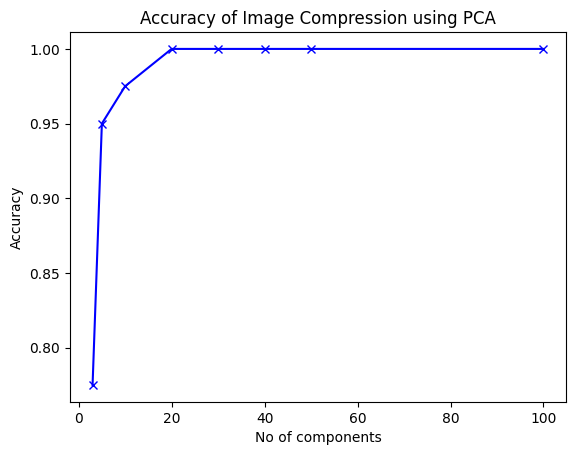

In [26]:
# your code here
accuracy_list_2 = []

for keys in components_res_dict:
    components_res_dict_list = components_res_dict[keys]
    total_instances = len(components_res_dict_list)
    cnt = 0
    for i in range(len(components_res_dict_list)):
        if(components_res_dict_list[i][2] == True):
            cnt += 1
    accuracy_list_2.append(cnt/total_instances)

print(components_list)
print(accuracy_list_2)

import matplotlib.pyplot as plt

plt.plot(components_list, accuracy_list_2, 'bx-')
plt.xlabel('No of components')
plt.ylabel('Accuracy')
plt.title('Accuracy of Image Compression using PCA')
plt.show()


#MSEs

In [27]:
# your code here
MSE_list_2 = []
log_MSE_list_2 = []

for keys in components_res_dict:
    MSE_list_2.append(components_res_dict[keys][1][5])
    log_MSE_list_2.append(components_res_dict[keys][1][6])

print(components_list)
print(MSE_list_2)
print(log_MSE_list_2)



[3, 5, 10, 20, 30, 40, 50, 100]
[array([3314.8878852]), array([3065.55039765]), array([2466.2081367]), array([2258.28211966]), array([2101.31880863]), array([2025.36185375]), array([1999.72686712]), array([1800.67314056])]
[array([8.10617908]), array([8.02798241]), array([7.81043708]), array([7.72235968]), array([7.65032043]), array([7.61350366]), array([7.60076588]), array([7.49591584])]


Plot Number of eigenvectors vs Mean Square Error

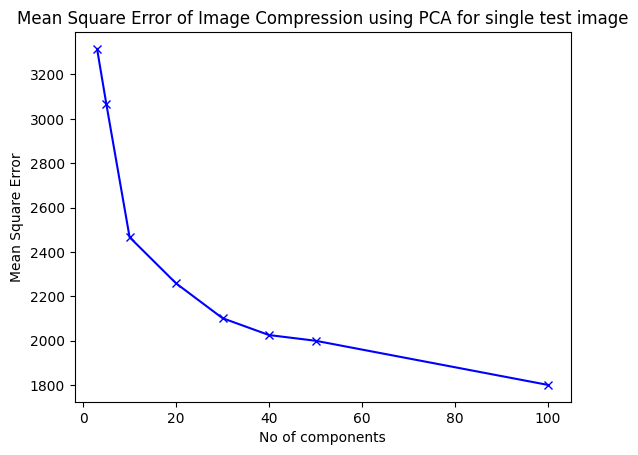

In [28]:
plt.plot(components_list, MSE_list_2, 'bx-')
plt.xlabel('No of components')
plt.ylabel('Mean Square Error')
plt.title('Mean Square Error of Image Compression using PCA for single test image')
plt.show()

Plot Number of eigenvectors vs Logarithmic Mean Square Error

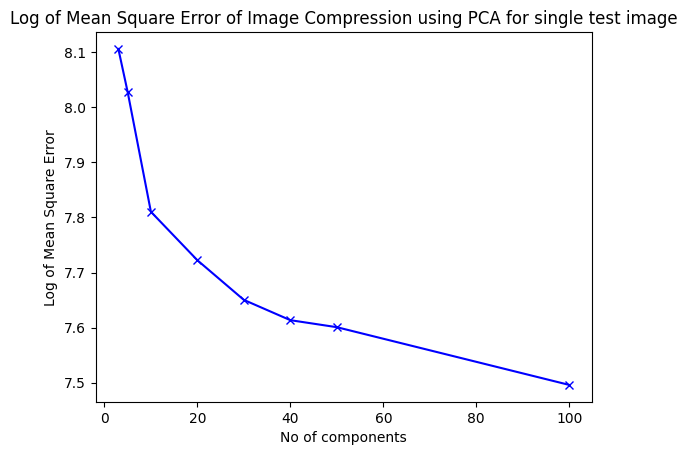

In [29]:
plt.plot(components_list, log_MSE_list_2, 'bx-')
plt.xlabel('No of components')
plt.ylabel('Log of Mean Square Error')
plt.title('Log of Mean Square Error of Image Compression using PCA for single test image')
plt.show()